In [1]:
library(DESeq2)
library("tximport")
library("rhdf5")
library(stringr)
library(dplyr)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGe

In [2]:
proj = "/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929"

In [3]:
s2c <- read.table(file.path(proj, 
                             "s2c.tsv"), 
                              header = TRUE, sep = "\t", stringsAsFactors=FALSE)

# get rid of the extra PT variable
s2c <- s2c %>% filter(grepl('Wapl', condition))

s2c$condition <- gsub('-', '_', s2c$condition) # apparently R wants  of factors in the design to only have letters, numbers, '_' and '.'
s2c$condition <- as.factor(s2c$condition)

In [4]:
s2c

X,sample,condition,path
<int>,<chr>,<fct>,<chr>
0,SRR12623461,Wapl_C20_96h,/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/SRX9106192/kallisto
1,SRR12623460,Wapl_C20_96h,/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/SRX9106191/kallisto
2,SRR12623459,Wapl_C20_48h,/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/SRX9106190/kallisto
3,SRR12623458,Wapl_C20_48h,/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/SRX9106189/kallisto
4,SRR12623457,Wapl_C20_24h,/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/SRX9106188/kallisto
5,SRR12623456,Wapl_C20_24h,/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/SRX9106187/kallisto
6,SRR12623455,Wapl_C20_6h,/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/SRX9106186/kallisto
7,SRR12623454,Wapl_C20_6h,/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/SRX9106185/kallisto
8,SRR12623453,Wapl_C20_0h,/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/SRX9106184/kallisto


In [5]:
# load conversion between transcripts and genes
ensembl_dir = "/project/fudenber_735/genomes/mm10/ensembl/ensembl_relational_downloads"
tx <- read.csv(file.path(ensembl_dir,"biomaRt_mm10_t2g.csv"))

In [6]:
TXNAME <- tx$ensembl_transcript_id
GENEID <- tx$ensembl_gene_id

In [7]:
tx2gene <- data.frame(TXNAME, GENEID)

In [8]:
files <- file.path(s2c$path, "abundance.h5")
names(files) <- s2c$sample

In [9]:
txi <- tximport(files, type="kallisto", tx2gene=tx2gene)

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



In [10]:
#s2c_wapl <- s2c %>% filter(grepl('Wapl', condition))

s2c$condition <- relevel(s2c$condition, "Wapl_C20_0h")

In [11]:
levels(s2c$condition)

[1] "Wapl_C20_0h"  "Wapl_C20_24h" "Wapl_C20_48h" "Wapl_C20_6h"  "Wapl_C20_96h"

# Exploratory Data Analysis

Following steps from Mike Love's tutorial and vignettes to ensure technical variation is accounted for:

(1) https://twitter.com/mikelove/status/1513468597288452097?lang=en

(2) https://f1000research.com/articles/4-1070#s2

(3) https://f1000research.com/articles/5-1438

(4) https://www.bioconductor.org/packages/devel/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#exploratory-analysis-and-visualization

In [12]:
# load the full dataset for exploratory analysis
dds <- DESeqDataSetFromTximport(txi, colData = s2c, design = ~condition)
                                                                                                  

using counts and average transcript lengths from tximport



In [13]:
nrow(dds)

[1] 29723

In [14]:
# filter out count matrix rows with many ones and zeros
keep <- rowSums(counts(dds)) > 1
dds <- dds[keep,]
nrow(dds)

[1] 21238

In [15]:
## an optional filter to add:

# # at least 3 samples with a count of 10 or higher
# keep <- rowSums(counts(dds) >= 10) >= 3

In [28]:
normalizationFactors(dds)

,SRR12623461,SRR12623460,SRR12623459,SRR12623458,SRR12623457,SRR12623456,SRR12623455,SRR12623454,SRR12623453,SRR12623452
ENSMUSG00000000001,1.0261481,1.065896,0.9872603,1.0339930,0.8937284,1.0754735,0.9741726,1.0287218,0.9345942,0.9948640
ENSMUSG00000000028,1.0394035,1.069173,0.9899089,1.0285188,0.8996112,1.0737625,0.9666387,1.0296180,0.9270406,0.9916499
ENSMUSG00000000031,0.6738371,1.524286,1.3226877,1.3626381,0.9579022,1.5944658,0.5220614,1.5785774,0.7920736,0.5418155
ENSMUSG00000000037,1.2758660,1.408438,0.6913396,0.6868846,1.0058986,1.1800942,0.9795580,1.1457302,0.6937308,1.2679664
ENSMUSG00000000056,1.0722125,1.072868,0.8092622,0.9490446,0.8916184,1.0961141,1.0547116,1.1231345,1.0827983,0.9029199
ENSMUSG00000000058,1.0261481,1.065896,0.9872603,1.0339930,0.8937284,1.0754735,0.9741726,1.0287218,0.9345942,0.9948640
ENSMUSG00000000078,1.0261481,1.065896,0.9872603,1.0339930,0.8937284,1.0754735,0.9741726,1.0287218,0.9345942,0.9948640
ENSMUSG00000000085,0.7373057,1.225753,0.8972746,1.0343805,0.8499647,1.1088256,1.0337221,1.0187294,1.1747659,1.0225057
ENSMUSG00000000088,1.0261481,1.065896,0.9872603,1.0339930,0.8937284,1.0754735,0.9741726,1.0287218,0.9345942,0.9948640
ENSMUSG00000000093,1.0261481,1.065896,0.9872603,1.0339930,0.8937284,1.0754735,0.9741726,1.0287218,0.9345942,0.9948640


In [16]:
# Choosing variance stabilizating transformation
vsd <- vst(dds, blind = FALSE)
head(assay(vsd), 3)

using 'avgTxLength' from assays(dds), correcting for library size



,SRR12623461,SRR12623460,SRR12623459,SRR12623458,SRR12623457,SRR12623456,SRR12623455,SRR12623454,SRR12623453,SRR12623452
ENSMUSG00000000001,11.474077,11.515972,11.534473,11.574881,11.542833,11.517522,11.530688,11.522411,11.595205,11.610071
ENSMUSG00000000028,10.557188,10.692554,10.845313,10.831302,10.881424,10.787351,10.994686,10.990791,10.914782,10.931851
ENSMUSG00000000031,9.385801,9.383585,9.387309,9.427155,9.395569,9.386941,9.388393,9.306532,9.387466,9.363957


In [17]:
rld <- rlog(dds, blind = FALSE)
head(assay(rld), 3)

using 'avgTxLength' from assays(dds), correcting for library size



,SRR12623461,SRR12623460,SRR12623459,SRR12623458,SRR12623457,SRR12623456,SRR12623455,SRR12623454,SRR12623453,SRR12623452
ENSMUSG00000000001,10.807658,10.861978,10.885811,10.937447,10.896531,10.863976,10.880950,10.870290,10.963157,10.981957
ENSMUSG00000000028,9.235121,9.464219,9.707237,9.685607,9.762284,9.616861,9.930506,9.925081,9.812547,9.838179
ENSMUSG00000000031,2.853625,2.851957,2.855037,2.891678,2.861711,2.854778,2.855419,2.802002,2.854969,2.838705


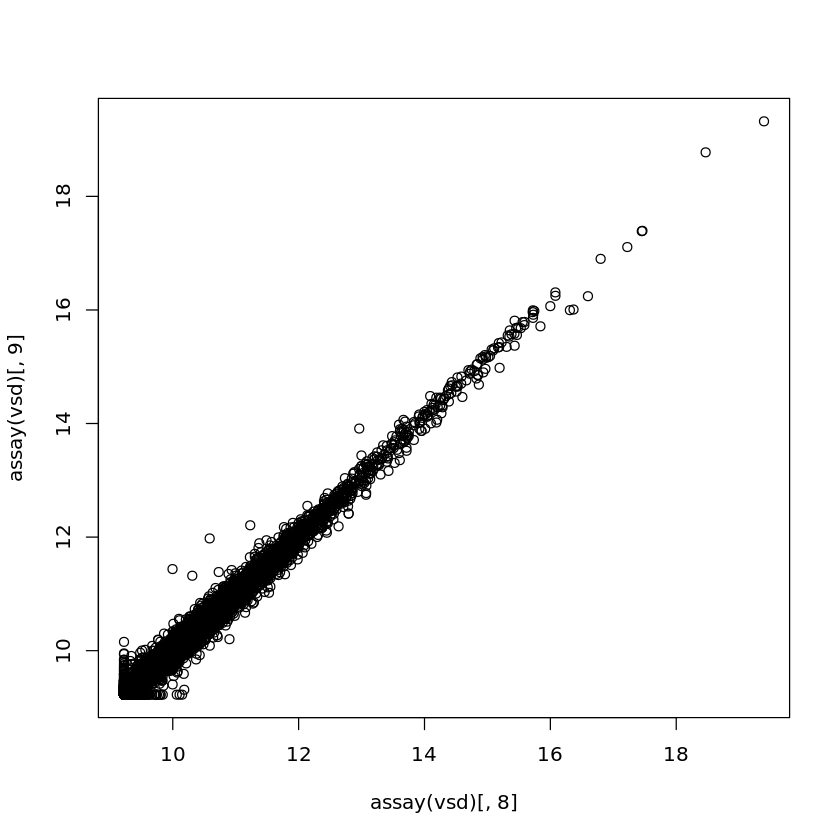

In [18]:
plot(assay(vsd)[, 8], assay(vsd)[, 9])

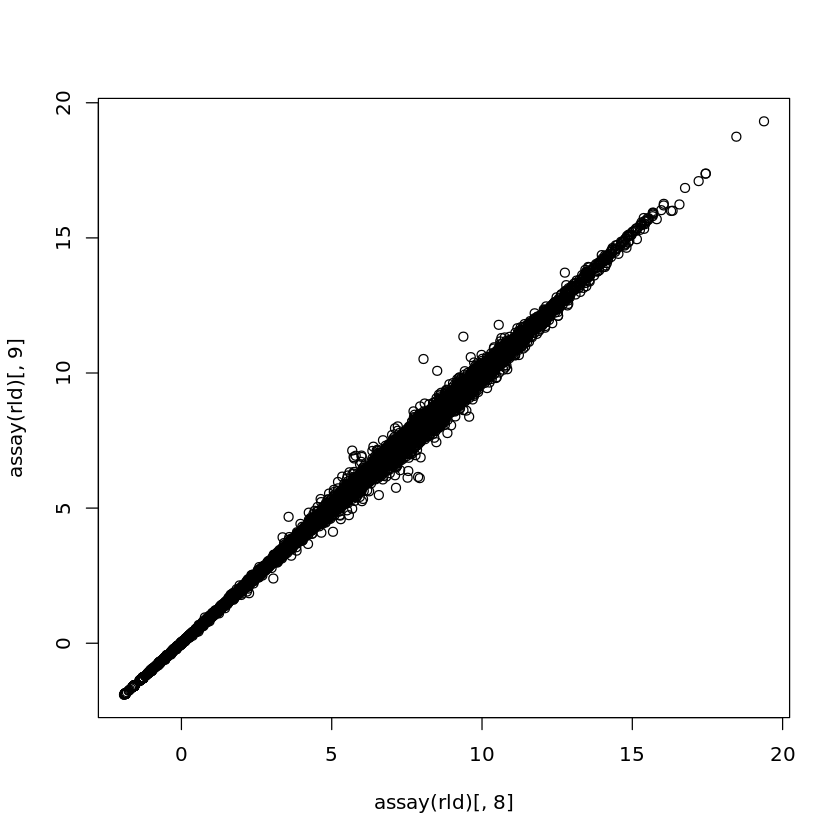

In [19]:
plot(assay(rld)[, 8], assay(rld)[, 9])

using 'avgTxLength' from assays(dds), correcting for library size

Warning message:
"`as_data_frame()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated."
Warning message:
"Computation failed in `stat_binhex()`:
"
Warning message:
"Computation failed in `stat_binhex()`:
"
Warning message:
"Computation failed in `stat_binhex()`:
"


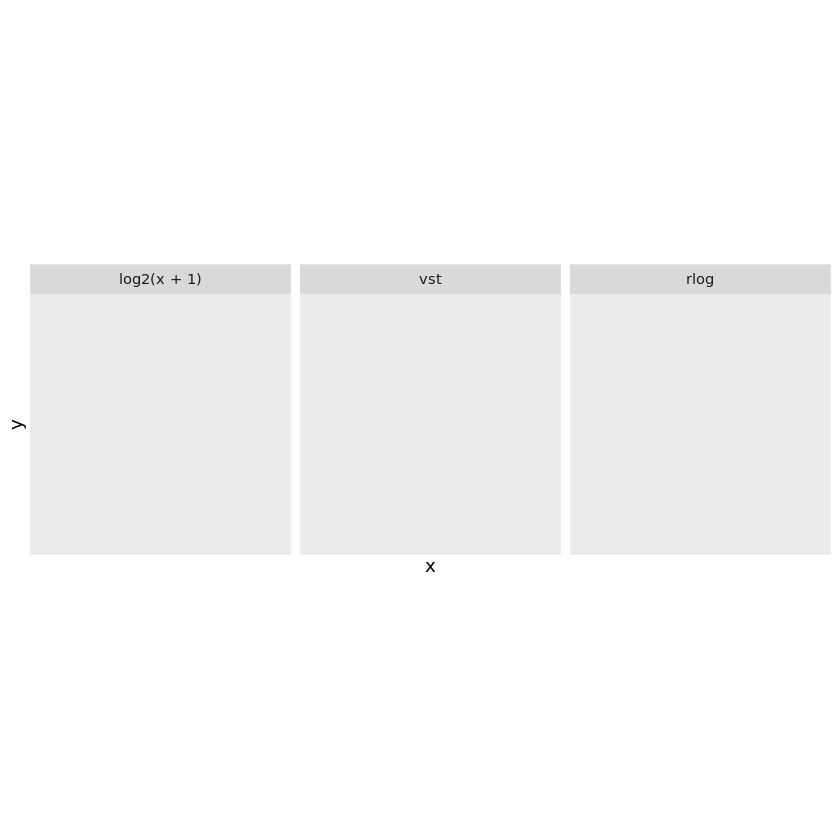

In [20]:
library("ggplot2")

dds <- estimateSizeFactors(dds)

df <- bind_rows(
  as_data_frame(log2(counts(dds, normalized=TRUE)[, 1:2]+1)) %>%
         mutate(transformation = "log2(x + 1)"),
  as_data_frame(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"),
  as_data_frame(assay(rld)[, 1:2]) %>% mutate(transformation = "rlog"))
  
colnames(df)[1:2] <- c("x", "y")  

lvls <- c("log2(x + 1)", "vst", "rlog")
df$transformation <- factor(df$transformation, levels=lvls)

ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

In [21]:
# Find euclidean distance between two samples
sampleDists <- dist(t(assay(rld)))


In [22]:
library("pheatmap")
library("RColorBrewer")

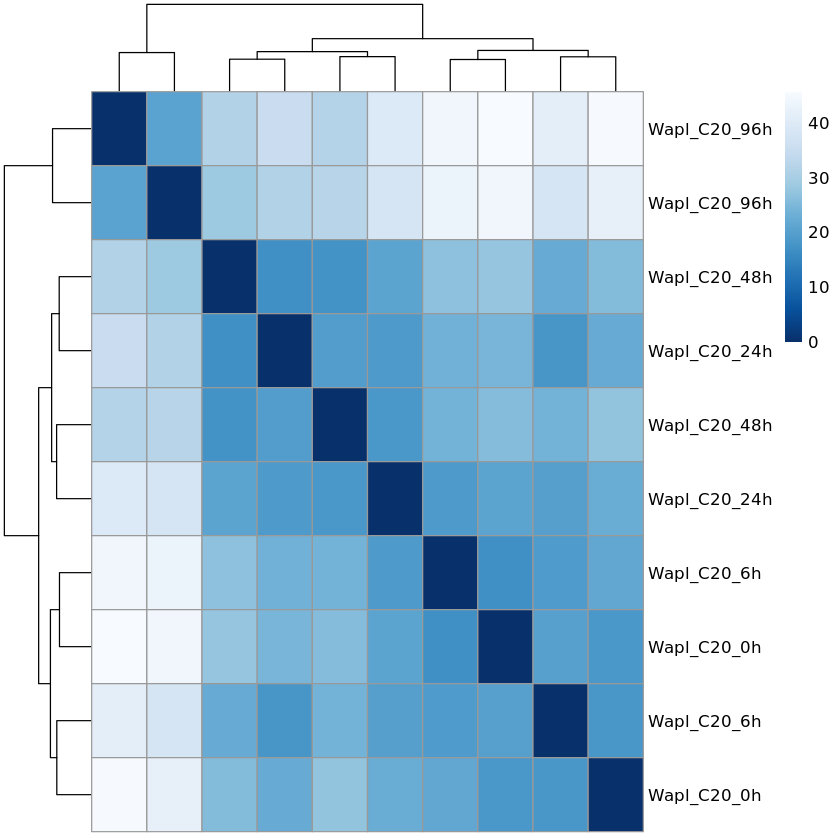

In [23]:
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$condition)
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

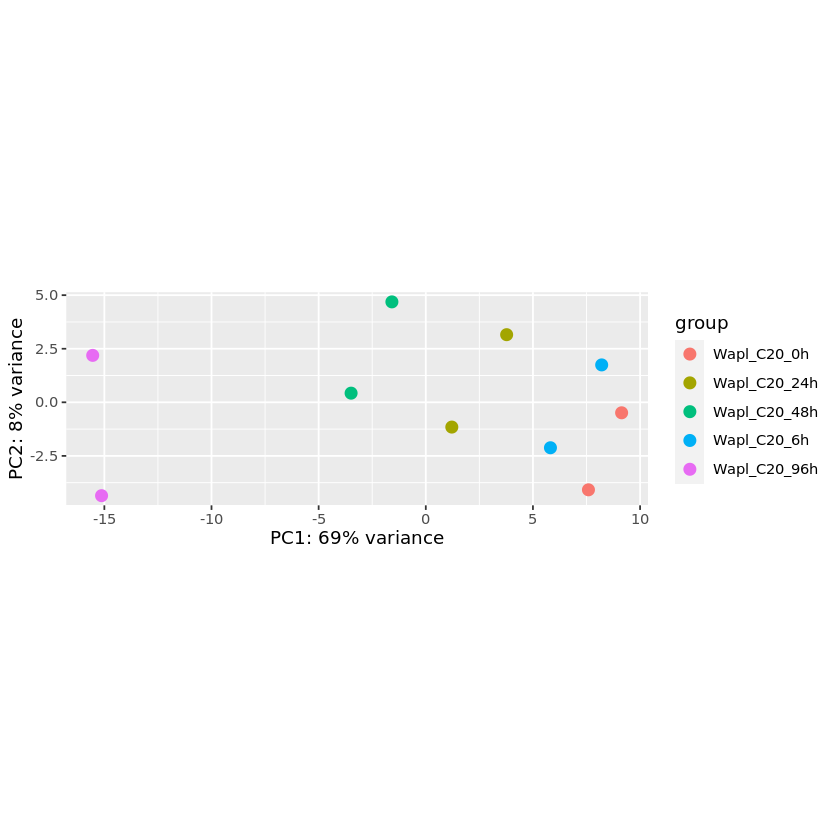

In [24]:
plotPCA(rld, intgroup = c("condition"))

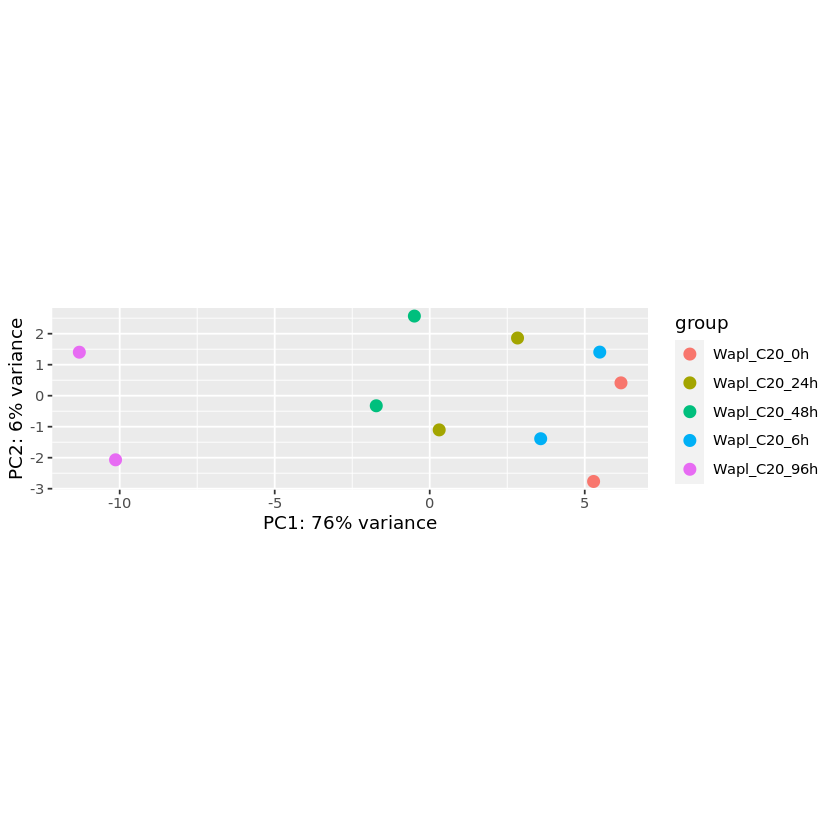

In [25]:
plotPCA(vsd, intgroup = c("condition"))

todo: also do PCA/cluster map with a separation by strain: dWapl + PT

### Notes:

These maps seem flipped from what I would expect -- it looks like the dWapl treatment continues to have an impact as time wears on).

Checking the paper: This seems to align with the DE results/analysis as given by the paper: https://www.nature.com/articles/s41588-020-00744-4/figures/9

Collapsing technical replicates
DESeq2 provides a function collapseReplicates which can assist in combining the counts from technical replicates into single columns of the count matrix. The term technical replicate implies multiple sequencing runs of the same library. You should not collapse biological replicates using this function. See the manual page for an example of the use of collapseReplicates.

### Different models/interaction terms:

* Time-course analysis with fission package:
    * e.g.: `ddsTC <- DESeqDataSet(fission, ~ strain + minute + strain:minute)`
    * design formula that models the strain difference at time 0, the difference over time, and any strain-specific differences over time (the interaction term strain:minute
* Then, statistical test comparing full (above) model, with all combos of interaction terms, vs 
    * Testing whether there are strain-specific changes across time (removes interaction term across strain and time)
    * genes with small p-value = genes that showed strain-specific effect at one or more time points (if both strains showed a change across time --> does not show as significant)
* 
    * e.g.: `ddsTC <- DESeq(ddsTC, test="LRT", reduced = ~ strain + minute)`

In [ ]:
# if we had a parallel test running for WT version, could run:

# ddsTC <- DESeqDataSEtFromTximport(tx_by_genes, colData = ??(do we include all cols), ~strain + timestamp + strain:timestamp)

# ddsTC <- DESeq(ddsTC, test="LRT", reduced = ~ strain + timestamp)

###### to give strain-specific effect

# ddsTC <- DESeq(ddsTC, test="LRT", reduced = ~ strain + minute)
# resTC <- results(ddsTC)
# resTC$symbol <- mcols(ddsTC)$symbol
# head(resTC[order(resTC$padj),],4)

# data <- plotCounts(ddsTC, which.min(resTC$padj),
#                    intgroup=c("minute",“strain"), returnData=TRUE)
# ggplot(data, aes(x=minute, y=count, color=strain, group=strain)) +
# geom_point() + stat_smooth(se=FALSE,method=“loess") + scale_y_log10()

###### generate wald-tests for each condition using the null hypotheses


## Basic Results

Following the vignette to model results for entire counts matrix, and then visualizing results of the individual wald tests for each pair-wise conditions

In [27]:
normalizationFactors(dds)

ERROR: Error in eval(expr, envir, enclos): object 'dds.normalizationFactors' not found


# Generating pair-wise DE

In [ ]:
## saving all .csvs and getting summaries to generate heatmaps for all of these conditions
wt_name = 'Wapl_C20_0h'
#s2c = s2c_wapl

for (cond in levels(s2c_wapl$condition)) {
    
    
    if (cond != wt_name) {
        
        print(paste("Performing test for condition:", cond))
        
        s2c_untreated_vs_variable <- s2c[ (s2c$condition==wt_name) | 
                                       (s2c$condition==cond) , ]

        files_untreated_vs_variable = files[s2c_untreated_vs_variable$sample]

        s2c_untreated_vs_variable$condition <-  factor(s2c_untreated_vs_variable$condition,
                                                    levels = c(wt_name, cond))
        tx_by_genes <- tximport(
                 files_untreated_vs_variable,
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )
        
        print("Variables in design ~condition looks like: ")
        print(~ condition)
        
        dds <- DESeqDataSetFromTximport(tx_by_genes,
                                colData = s2c_untreated_vs_variable,
                                design = ~ condition)
        
        
        dds <- DESeq(dds)
        
        res <- results(dds, name=paste('condition_', cond, '_vs_', wt_name, sep=""), alpha=0.05)
        
        print(head(res, 6))
        
        # save as .csv so can generate heat plots, analyze elsewhere, etc
        write.csv(res,file.path(proj, "deseq-mm10-results", paste("pairwise_deseq_wt_", cond, ".csv", sep="")))
        
        # printing some general stats about the significant set
        print(summary(results(dds, alpha=0.05)))
        
    }
    
}